# ORF recognition by MLP

So far, no MLP has exceeded 50% accurcy on any ORF problem.
Here, try a variety of things.

RNA length 16, CDS length 8.
No luck with 32 neurons or 64 neurons
Instead of sigmoid, tried tanh and relu.
Instead of 4 layers, tried 1.
RNA length 12, CDS length 6.
2 layers of 32 neurons, sigmoid.
Even 512 neurons, rectangular or triangular, didn't work.
Move INPUT_SHAPE from compile() to first layer parameter. 

This works: All PC='AC'*, all NC='GT'*. 
100% accurate on one epoch with 2 layers of 12 neurons.

Nothing works! Now suspect the data preparation is incorrect. Try trivializing the problem by always adding ATG or TAG.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-23 17:58:26 UTC'

In [2]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=32            # how long is each sequence
CDS_LEN=16           # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (None,RNA_LEN,ALPHABET) # MLP requires batch size None
FILTERS = 16   # how many different patterns the model looks for
CELLS = 16
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=50  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 33 trials to reach 10 per class.
It took 143442 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [6]:
# Make the problem super easy!
def trivialize_sequences(list_of_seq,option):
    num_seq = len(list_of_seq)
    for i in range(0,num_seq):
        seq = list_of_seq[i]
        if option==0:
            list_of_seq[i] = 'TTTTTT'+seq[6:]
        else:
            list_of_seq[i] = 'AAAAAA'+seq[6:]

if False:
    print("Trivialize...")
    trivialize_sequences(pc_all,1)
    print("Trivial PC:",pc_all[:5])
    print("Trivial PC:",pc_all[-5:])
    trivialize_sequences(nc_all,0)
    print("Trivial NC:",nc_all[:5])
    print("Trivial NC:",nc_all[-5:])

In [7]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 32.0
Average ORF length: 19.671818181818182
NC seqs
Average RNA length: 32.0
Average ORF length: 2.855909090909091


In [8]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [9]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [10]:
print(len(X),"sequences total")
print(len(X[0]),"bases/sequence")
print(len(X[0][0]),"dimensions/base")
#print(X[0])
print(type(X[0]))
print(X[0].shape)

64000 sequences total
32 bases/sequence
4 dimensions/base
<class 'numpy.ndarray'>
(32, 4)


In [11]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32,
                 input_shape=INPUT_SHAPE ))   
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    #dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    #dnn.build() 
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn

model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 32, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 2,897
Trainable params: 2,897
Non-trainable params: 0
__________________

In [12]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (None, 32, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 17s 3ms/step - loss: 0.6601 - accuracy: 0.5969 - val_loss: 0.5797 - val_accuracy: 0.7062
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5746 - accuracy: 0.7103 - val_loss: 0.5760 - val_accuracy: 0.7054
Epoch 3/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5699 - accuracy: 0.7116 - val_loss: 0.5677 - val_accuracy: 0.7094
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5573 - accuracy: 0.7184 - val_loss: 0.5464 - val_accuracy: 0.7226
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5256 - accuracy: 0.7403 - val_loss: 0.4922 - val_accuracy: 0.7616
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 6/50
1334/1334 [===

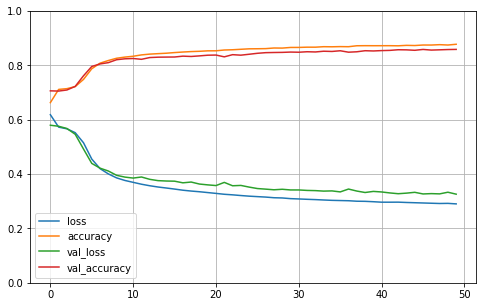

MODEL
make_DNN
input shape: (None, 32, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 5s 3ms/step - loss: 0.6613 - accuracy: 0.5905 - val_loss: 0.5746 - val_accuracy: 0.7101
Epoch 2/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5766 - accuracy: 0.7088 - val_loss: 0.5702 - val_accuracy: 0.7134
Epoch 3/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5614 - accuracy: 0.7207 - val_loss: 0.5468 - val_accuracy: 0.7302
Epoch 4/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5296 - accuracy: 0.7430 - val_loss: 0.4940 - val_accuracy: 0.7759
Epoch 5/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.4791 - accuracy: 0.7810 - val_loss: 0.4348 - val_accuracy: 0.7988
Epoch 6/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.4252 - accuracy: 0.8082 - val_loss: 0.4024 - val_accuracy: 0.8220
Epoch 7/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.3861 - accur

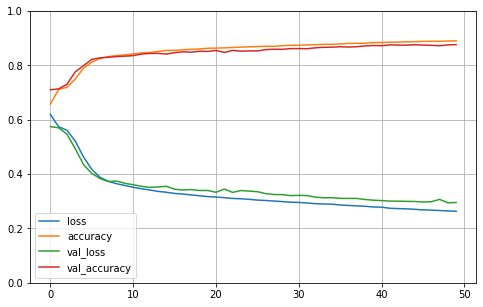

MODEL
make_DNN
input shape: (None, 32, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 5s 3ms/step - loss: 0.6841 - accuracy: 0.5660 - val_loss: 0.5790 - val_accuracy: 0.7074
Epoch 2/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5776 - accuracy: 0.7095 - val_loss: 0.5731 - val_accuracy: 0.7115
Epoch 3/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5707 - accuracy: 0.7128 - val_loss: 0.5656 - val_accuracy: 0.7137
Epoch 4/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5670 - accuracy: 0.7087 - val_loss: 0.5519 - val_accuracy: 0.7213
Epoch 5/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5480 - accuracy: 0.7223 - val_loss: 0.5263 - val_accuracy: 0.7372
Epoch 6/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.5130 - accuracy: 0.7488 - val_loss: 0.4692 - val_accuracy: 0.7727
Epoch 7/50
1334/1334 [==============================] - 4s 3ms/step - loss: 0.4499 - accur

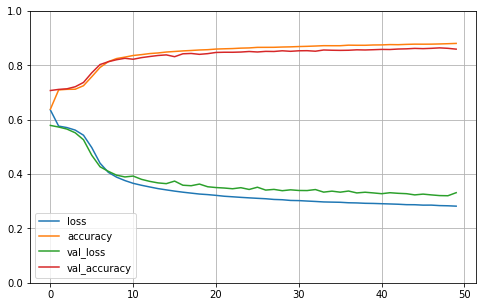

In [13]:
do_cross_validation(X,y)

In [14]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 87.15%


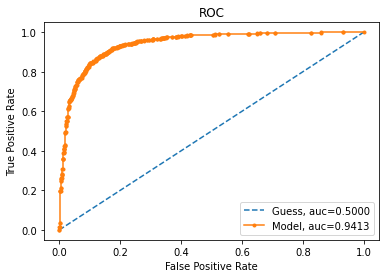

AUC: 94.13%


In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [16]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-23 18:11:08 UTC'